In [ ]:
import os
import glob
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive

# Check if the drive is already mounted by checking if /content/drive exists
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')  # Mount if it doesn't exist
else:
    print("Drive already mounted at /content/drive")

# Continue with the rest of your code

Mounted at /content/drive


##Data Preparation [24] - Divide to 72:8:20


In [ ]:
import os
import shutil
import random

new_data_path = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire"
img_src_path = os.path.join(new_data_path, "all_data/images")
lbl_src_path = os.path.join(new_data_path, "all_data/labels")
split_name = "72:8:20"
split_path = os.path.join(new_data_path, split_name)


all_images = [
    f for f in os.listdir(img_src_path)
    if f.endswith(".jpg") and os.path.exists(os.path.join(lbl_src_path, f.replace(".jpg", ".txt")))
]

print(f"📊 Found {len(all_images)} valid image-label pairs.")

random.shuffle(all_images)
total = len(all_images)
train_cut = int(0.72 * total)
val_cut = int(0.08 * total)

train_files = all_images[:train_cut]
val_files = all_images[train_cut:train_cut + val_cut]
test_files = all_images[train_cut + val_cut:]

splits = {
    "train": train_files,
    "val": val_files,
    "test": test_files
}

for split, file_list in splits.items():
    img_out = os.path.join(split_path, split, "images")
    lbl_out = os.path.join(split_path, split, "labels")
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    count = 0
    for fname in file_list:
        src_img = os.path.join(img_src_path, fname)
        src_lbl = os.path.join(lbl_src_path, fname.replace(".jpg", ".txt"))

        dst_img = os.path.join(img_out, fname)
        dst_lbl = os.path.join(lbl_out, fname.replace(".jpg", ".txt"))

        if os.path.exists(src_lbl):
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_lbl, dst_lbl)
            count += 1

    print(f"✅ {split.upper()}: Copied {count} image-label pairs.")

print("\n🎉 Done splitting into 72:8:20!")


📊 Found 21527 valid image-label pairs.
✅ TRAIN: Copied 15499 image-label pairs.
✅ VAL: Copied 1722 image-label pairs.
✅ TEST: Copied 4306 image-label pairs.

🎉 Done splitting into 72:8:20!


In [ ]:
import os

base_path = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20"
splits = ["train", "val", "test"]

print("📊 File counts per split:\n")
for split in splits:
    img_dir = os.path.join(base_path, split, "images")
    lbl_dir = os.path.join(base_path, split, "labels")

    img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
    lbl_files = [f for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    print(f"📁 {split.upper()}:")
    print(f"   🖼️ Images : {len(img_files)}")
    print(f"   📝 Labels : {len(lbl_files)}")
    print()


📊 File counts per split:

📁 TRAIN:
   🖼️ Images : 15499
   📝 Labels : 15499

📁 VAL:
   🖼️ Images : 1722
   📝 Labels : 1722

📁 TEST:
   🖼️ Images : 4306
   📝 Labels : 4306



##Data Augmentation [23] - HE Implementation

In [ ]:
import os
import cv2
import shutil

# ===== Parameters =====
IMG_SIZE = (224, 224)

# ===== HE Function =====
def apply_he_rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply Histogram Equalization (instead of CLAHE)
    he = cv2.equalizeHist(l)

    limg = cv2.merge((he, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# ===== Apply HE to All Images in a Folder =====
def apply_he(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            img = cv2.imread(input_path)
            if img is None:
                print(f"⚠️ Warning: Failed to load image {input_path}")
                continue

            img = cv2.resize(img, IMG_SIZE)
            enhanced_img = apply_he_rgb(img)
            cv2.imwrite(output_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))
            count += 1
    print(f"✅ HE applied to {count} image(s) in '{input_folder}'")

# ===== Copy Labels (.txt files) from Input to Output Folder =====
def copy_labels(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            shutil.copy2(input_path, output_path)
            count += 1
    print(f"✅ Copied {count} label file(s) from '{input_folder}'")

# ===== Process All Splits (train, val, test) =====
splits = ["train", "val", "test"]  # include test if needed
base_input = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20"
base_output = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20"  # <- change folder name to HE

for split in splits:
    print(f"\n🚀 Processing split: {split.upper()}")

    input_img_folder = os.path.join(base_input, split, "images")
    output_img_folder = os.path.join(base_output, split, "images")
    input_lbl_folder = os.path.join(base_input, split, "labels")
    output_lbl_folder = os.path.join(base_output, split, "labels")

    apply_he(input_img_folder, output_img_folder)
    copy_labels(input_lbl_folder, output_lbl_folder)

print("\n🎉 All splits finished processing!")



🚀 Processing split: TRAIN
✅ HE applied to 15499 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/images'
✅ Copied 15499 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/labels'

🚀 Processing split: VAL
✅ HE applied to 1722 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/val/images'
✅ Copied 1722 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/val/labels'

🚀 Processing split: TEST
✅ HE applied to 4306 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images'
✅ Copied 4306 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels'

🎉 All splits finished processing!


In [ ]:
import os
import cv2
import shutil

# ===== HE Function =====
def apply_he_rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply Histogram Equalization
    he = cv2.equalizeHist(l)

    limg = cv2.merge((he, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# ===== Apply HE to All Images in a Folder =====
def apply_he(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            img = cv2.imread(input_path)
            if img is None:
                print(f"⚠️ Warning: Failed to load image {input_path}")
                continue

            enhanced_img = apply_he_rgb(img)
            cv2.imwrite(output_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))
            count += 1
    print(f"✅ HE applied to {count} image(s) in '{input_folder}'")

# ===== Copy Labels (.txt files) from Input to Output Folder =====
def copy_labels(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            shutil.copy2(input_path, output_path)
            count += 1
    print(f"✅ Copied {count} label file(s) from '{input_folder}'")

# ===== Only Process TEST Split =====
input_img_folder = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images"
output_img_folder = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/testNEW/images"
input_lbl_folder = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels"
output_lbl_folder = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/testNEW/labels"

print("🚀 Processing TEST split only...")
apply_he(input_img_folder, output_img_folder)
copy_labels(input_lbl_folder, output_lbl_folder)

print("\n🎉 Finished processing TEST split only!")


🚀 Processing TEST split only...
✅ HE applied to 4306 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images'
✅ Copied 4306 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels'

🎉 Finished processing TEST split only!


##Data Augmentation [23] - CLAHE Implementation

In [ ]:
import os
import cv2
import shutil

# ===== CLAHE Parameters =====
IMG_SIZE = (224, 224)
CLIP_LIMIT = 1.0
TILE_GRID_SIZE = (20, 20)

# ===== CLAHE Function =====
def apply_clahe_rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=CLIP_LIMIT, tileGridSize=TILE_GRID_SIZE)
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# ===== Apply CLAHE to All Images in a Folder =====
def apply_clahe(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            img = cv2.imread(input_path)
            if img is None:
                print(f"⚠️ Warning: Failed to load image {input_path}")
                continue

            img = cv2.resize(img, IMG_SIZE)
            enhanced_img = apply_clahe_rgb(img)
            cv2.imwrite(output_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))
            count += 1
    print(f"✅ CLAHE applied to {count} image(s) in '{input_folder}'")

# ===== Copy Labels (.txt files) from Input to Output Folder =====
def copy_labels(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            shutil.copy2(input_path, output_path)
            count += 1
    print(f"✅ Copied {count} label file(s) from '{input_folder}'")

# ===== Process All Splits (train, val, test) =====
splits = ["train", "val", "test"]  # ← add "test" here if redoing
base_input = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20"
base_output = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20"

for split in splits:
    print(f"\n🚀 Processing split: {split.upper()}")

    input_img_folder = os.path.join(base_input, split, "images")
    output_img_folder = os.path.join(base_output, split, "images")
    input_lbl_folder = os.path.join(base_input, split, "labels")
    output_lbl_folder = os.path.join(base_output, split, "labels")

    apply_clahe(input_img_folder, output_img_folder)
    copy_labels(input_lbl_folder, output_lbl_folder)

print("\n🎉 All splits finished processing!")



🚀 Processing split: TRAIN
✅ CLAHE applied to 15499 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/images'
✅ Copied 15499 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/labels'

🚀 Processing split: VAL
✅ CLAHE applied to 1722 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/val/images'
✅ Copied 1722 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/val/labels'

🚀 Processing split: TEST
✅ CLAHE applied to 4306 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images'
✅ Copied 4306 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels'

🎉 All splits finished processing!


In [ ]:
import os
import cv2
import shutil

# ===== CLAHE Parameters =====
CLIP_LIMIT = 1.0
TILE_GRID_SIZE = (20, 20)

# ===== CLAHE Function =====
def apply_clahe_rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=CLIP_LIMIT, tileGridSize=TILE_GRID_SIZE)
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# ===== Apply CLAHE to All Images in a Folder =====
def apply_clahe(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            img = cv2.imread(input_path)
            if img is None:
                print(f"⚠️ Warning: Failed to load image {input_path}")
                continue

            # ❌ Hapus resize, biarkan ukuran asli
            enhanced_img = apply_clahe_rgb(img)
            cv2.imwrite(output_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))
            count += 1
    print(f"✅ CLAHE applied to {count} image(s) in '{input_folder}'")

# ===== Copy Labels (.txt files) from Input to Output Folder =====
def copy_labels(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            shutil.copy2(input_path, output_path)
            count += 1
    print(f"✅ Copied {count} label file(s) from '{input_folder}'")

# ===== Only Process TEST Split =====
input_img_folder = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images"
output_img_folder = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images"
input_lbl_folder = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels"
output_lbl_folder = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/labels"

print("🚀 Processing TEST split only...")
apply_clahe(input_img_folder, output_img_folder)
copy_labels(input_lbl_folder, output_lbl_folder)

print("\n🎉 Finished processing TEST split only!")


🚀 Processing TEST split only...
✅ CLAHE applied to 4306 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images'
✅ Copied 4306 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels'

🎉 Finished processing TEST split only!


##Data Augmentation - DBST-LCM CLAHE Implementation [5]

In [ ]:
import os
import cv2
import numpy as np
import shutil

# ===== General Parameters =====
IMG_SIZE = (224, 224)
CLIP_LIMIT = 1.0
BLOCK_SIZES = [8, 16, 32, 64]

# ===== DBST-LCM CLAHE Core Function =====
def apply_dbst_lcm_clahe(image, base_clip_limit=CLIP_LIMIT, block_sizes=BLOCK_SIZES):
    def calculate_psnr(original, enhanced):
        mse = np.mean((original - enhanced) ** 2)
        if mse == 0:
            return float('inf')
        PIXEL_MAX = 255.0
        return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    psnr_values = []
    clahe_results = []

    for size in block_sizes:
        clahe = cv2.createCLAHE(clipLimit=base_clip_limit, tileGridSize=(size, size))
        enhanced_l = clahe.apply(l)
        psnr = calculate_psnr(l, enhanced_l)
        psnr_values.append(psnr)
        clahe_results.append(enhanced_l)

    best_idx = np.argmax(psnr_values)
    best_l = clahe_results[best_idx]

    final_lab = cv2.merge((best_l, a, b))
    final_rgb = cv2.cvtColor(final_lab, cv2.COLOR_LAB2RGB)
    return final_rgb

# ===== Apply DBST-LCM CLAHE to All Images in a Folder =====
def apply_dbst_clahe_to_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            img = cv2.imread(input_path)
            if img is None:
                print(f"⚠️ Warning: Failed to load image {input_path}")
                continue

            img = cv2.resize(img, IMG_SIZE)
            enhanced_img = apply_dbst_lcm_clahe(img)
            cv2.imwrite(output_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))
            count += 1
    print(f"✅ DBST-LCM CLAHE applied to {count} image(s) in '{input_folder}'")

# ===== Copy Labels (.txt files) from Input to Output Folder =====
def copy_labels(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            shutil.copy2(input_path, output_path)
            count += 1
    print(f"✅ Copied {count} label file(s) from '{input_folder}'")

# ===== Process All Splits (train, val, test) =====
splits = ["train", "val", "test"]
base_input = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20"
base_output = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_DBSTLCMCLAHE/72:8:20"

for split in splits:
    print(f"\n🚀 Processing split: {split.upper()}")

    input_img_folder = os.path.join(base_input, split, "images")
    output_img_folder = os.path.join(base_output, split, "images")
    input_lbl_folder = os.path.join(base_input, split, "labels")
    output_lbl_folder = os.path.join(base_output, split, "labels")

    apply_dbst_clahe_to_folder(input_img_folder, output_img_folder)
    copy_labels(input_lbl_folder, output_lbl_folder)

print("\n🎉 All splits finished processing with DBST-LCM CLAHE!")



🚀 Processing split: TRAIN
✅ DBST-LCM CLAHE applied to 15499 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/images'
✅ Copied 15499 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/labels'

🚀 Processing split: VAL
✅ DBST-LCM CLAHE applied to 1722 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/val/images'
✅ Copied 1722 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/val/labels'

🚀 Processing split: TEST
✅ DBST-LCM CLAHE applied to 4306 image(s) in '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images'
✅ Copied 4306 label file(s) from '/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/labels'

🎉 All splits finished processing with DBST-LCM CLAHE!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=40,             # Rotate images
    width_shift_range=0.2,         # Shift horizontally
    height_shift_range=0.2,        # Shift vertically
    brightness_range=[0.8, 1.2],   # Random brightness
    horizontal_flip=True,          # Flip horizontally
    vertical_flip=True             # Flip vertically
)

# Example: Load images from a directory
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/YourFolder/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'       # or 'binary' or 'sparse'
)



##❌Image Enhancement [23] CLAHE -> MobileNet for the model used

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

# ===== Parameters =====
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
CLIP_LIMIT = 1.0
TILE_GRID_SIZE = (20, 20)

# ===== CLAHE Preprocessing Function =====
def apply_clahe_rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=CLIP_LIMIT, tileGridSize=TILE_GRID_SIZE)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# ===== Load Dataset with CLAHE Applied =====
def load_dataset_with_clahe(image_folder, label_rule):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
    images = []
    labels = []

    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = apply_clahe_rgb(img)
        img = img.astype("float32") / 255.0  # Normalize
        images.append(img)

        # === Label rule: you can customize this ===
        if label_rule == 'fire_in_filename':
            label = 1 if 'fire' in img_path.lower() else 0
        else:
            label = 0  # Default
        labels.append(label)

    images = np.array(images)
    labels = to_categorical(np.array(labels), num_classes=2)
    return images, labels

# ===== Load your data =====
# Change this to match your data path
image_folder = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/train/images"
X, y = load_dataset_with_clahe(image_folder, label_rule='fire_in_filename')

# ===== Train-test split =====
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Build MobileNet Model =====
base_model = MobileNet(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)            # global average pooling
x = Flatten()(x)                           # flatten
x = Dense(128, activation='relu')(x)       # dense ReLU
x = Dense(64, activation='relu')(x)        # dense ReLU
predictions = Dense(2, activation='softmax')(x)  # dense softmax

model = Model(inputs=base_model.input, outputs=predictions)

# ===== Compile Model =====
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===== Train Model =====
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


##Data Training YOLOv12 [24]

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load model
model = YOLO('/content/drive/MyDrive/RBDM_Vita/yolo12n.pt')

# Train model
model.train(
    data='/content/drive/MyDrive/RBDM_Vita/Fire-Detection-main/data/NewDfire720820_HE.yaml',
    epochs=100,
    batch=64,
    imgsz=640
)

# Print optimizer used
print("Optimizer used:", model.trainer.optimizer)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/RBDM_Vita/Fire-Detection-main/data/NewDfire720820_HE.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7,

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

 21        [14, 17, 20]  1    431062  ultralytics.nn.modules.head.Detect           [2, [64, 128, 256]]           
YOLOv12n summary: 272 layers, 2,568,438 parameters, 2,568,422 gradients, 6.5 GFLOPs

Transferred 640/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 13.4±7.4 MB/s, size: 19.4 KB)


train: Scanning /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/train/labels... 15499 images, 7044 backgrounds, 4 corrupt: 100%|██████████| 15499/15499 [03:29<00:00, 74.02it/s] 

train: /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/train/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0297]
train: /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/train/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0156]
train: /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/train/images/WEB11598.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0359]
train: /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/train/images/WEB11600.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0562]


train: New cache created: /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 3.2±1.3 MB/s, size: 22.4 KB)


val: Scanning /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/val/labels... 1722 images, 790 backgrounds, 0 corrupt: 100%|██████████| 1722/1722 [00:09<00:00, 187.92it/s]


val: New cache created: /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.8G      1.641      3.378      1.675         14        640: 100%|██████████| 243/243 [01:36<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


                   all       1722       2078       0.24      0.324      0.189     0.0723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.9G      1.707      2.534      1.686         23        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


                   all       1722       2078      0.258      0.282      0.163     0.0585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.9G      1.856      2.439       1.83         21        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


                   all       1722       2078      0.046     0.0868      0.028    0.00864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.9G       1.91      2.423      1.899         19        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


                   all       1722       2078      0.204      0.191     0.0994     0.0387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.9G      1.798      2.209      1.803          8        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


                   all       1722       2078      0.269      0.254      0.189     0.0728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.9G       1.75      2.067      1.748         17        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


                   all       1722       2078      0.436      0.388      0.351      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.9G      1.707      1.971      1.711         13        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


                   all       1722       2078      0.423       0.39      0.367      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.9G      1.679      1.938      1.703          9        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


                   all       1722       2078      0.486      0.426      0.421      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.9G      1.648      1.868      1.674         20        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


                   all       1722       2078      0.545       0.45      0.479      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        14G       1.64      1.814      1.661         10        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


                   all       1722       2078       0.51      0.449      0.447      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100        14G      1.605      1.773      1.637          9        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


                   all       1722       2078      0.512       0.42       0.43      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100        14G      1.591      1.744      1.624         18        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


                   all       1722       2078      0.521      0.462      0.464      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100        14G      1.585      1.714       1.61         23        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


                   all       1722       2078      0.582       0.49      0.528      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100        14G      1.574      1.684      1.607         13        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


                   all       1722       2078      0.576      0.525      0.534      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100        14G      1.561      1.644      1.597         26        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.53it/s]

                   all       1722       2078      0.599      0.529      0.558       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100        14G      1.556      1.631      1.586         18        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


                   all       1722       2078      0.643      0.549      0.592      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100        14G      1.545      1.623      1.578         14        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


                   all       1722       2078      0.626      0.504      0.566       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100        14G      1.532      1.581      1.573          9        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


                   all       1722       2078      0.623      0.559      0.592      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100        14G      1.535      1.586      1.571          3        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


                   all       1722       2078      0.634      0.566      0.617       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.1G      1.524      1.557      1.559         13        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

                   all       1722       2078      0.655       0.57      0.626      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.1G      1.513      1.547      1.556         29        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


                   all       1722       2078      0.645      0.581      0.628      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.1G      1.512       1.52      1.554          8        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


                   all       1722       2078      0.638      0.593      0.634       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.1G        1.5      1.516      1.541          2        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


                   all       1722       2078      0.664      0.592      0.644      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.1G       1.49      1.504      1.541         16        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all       1722       2078      0.669      0.579      0.649      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.1G      1.486       1.48      1.532         31        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


                   all       1722       2078      0.689      0.586      0.655      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.1G      1.484       1.47      1.524         10        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


                   all       1722       2078      0.669      0.616      0.667      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.1G      1.473      1.453      1.517         15        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


                   all       1722       2078      0.681      0.602      0.672      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.1G      1.475      1.437      1.509         15        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


                   all       1722       2078      0.693      0.602      0.667      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.1G      1.463      1.429      1.505          7        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


                   all       1722       2078      0.708      0.614      0.686      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.2G      1.466      1.431      1.511          9        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


                   all       1722       2078      0.682       0.63      0.689      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.2G      1.463      1.417      1.509         25        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

                   all       1722       2078      0.708      0.623      0.691      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.2G      1.447      1.396      1.504         18        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all       1722       2078      0.728       0.61      0.693      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.2G      1.436      1.383      1.491         12        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


                   all       1722       2078      0.708      0.614      0.697      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.2G      1.442      1.373       1.49          8        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


                   all       1722       2078      0.709      0.636      0.711       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.2G      1.442      1.371      1.497         11        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all       1722       2078      0.698      0.653      0.713      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.2G      1.436      1.367      1.488         17        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


                   all       1722       2078      0.721      0.638      0.712      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.2G      1.431      1.356      1.479         19        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


                   all       1722       2078      0.698      0.638      0.706      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.2G      1.422      1.351      1.478         12        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


                   all       1722       2078      0.721      0.641      0.711      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.2G      1.423      1.341      1.471         14        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all       1722       2078      0.725      0.632      0.716        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.3G      1.414      1.328      1.471         20        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


                   all       1722       2078      0.739      0.631      0.717      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.3G      1.416      1.316      1.471         30        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


                   all       1722       2078      0.727      0.644      0.723      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.3G      1.405      1.303      1.462         10        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all       1722       2078      0.742      0.645      0.724      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.3G      1.404      1.302      1.458         23        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


                   all       1722       2078      0.727      0.645      0.724      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.3G      1.399      1.286      1.456         16        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


                   all       1722       2078      0.731      0.641      0.725      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.3G      1.408      1.291      1.458         12        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


                   all       1722       2078      0.731      0.646      0.727      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.3G      1.385      1.275      1.453         10        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all       1722       2078      0.725      0.661      0.728       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.3G      1.381      1.272      1.449         23        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


                   all       1722       2078      0.718      0.672      0.731      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.3G      1.382      1.257      1.444         18        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


                   all       1722       2078      0.743      0.652      0.732      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.3G      1.378      1.251      1.443         11        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

                   all       1722       2078      0.732      0.657      0.729      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.4G      1.377      1.253      1.438         15        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


                   all       1722       2078       0.74      0.659      0.734      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.4G      1.364      1.238      1.429          4        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


                   all       1722       2078      0.745      0.649      0.731      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.4G      1.376      1.241      1.435         18        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


                   all       1722       2078      0.733      0.658      0.732      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.4G      1.357      1.217      1.425         18        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


                   all       1722       2078      0.743      0.665      0.737       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.4G      1.358      1.213      1.422         10        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


                   all       1722       2078      0.743      0.661      0.737      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.4G      1.357      1.204      1.421         14        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


                   all       1722       2078       0.74      0.658      0.741      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.4G      1.343      1.203      1.416         15        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


                   all       1722       2078      0.754      0.656      0.743      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      14.4G      1.346      1.184      1.416         16        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


                   all       1722       2078      0.769      0.646      0.743      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.4G      1.348      1.189      1.414         16        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


                   all       1722       2078      0.757      0.659      0.743      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.4G      1.334      1.179      1.411          8        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all       1722       2078       0.75      0.661      0.743      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.5G      1.337       1.18      1.403         14        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


                   all       1722       2078      0.725      0.679      0.743      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.5G      1.333      1.162      1.399          7        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


                   all       1722       2078      0.727      0.677      0.744      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.5G      1.332      1.164      1.403         11        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


                   all       1722       2078      0.735      0.673      0.742      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.5G      1.328      1.151      1.395          6        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


                   all       1722       2078      0.733      0.678      0.743      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.5G      1.316      1.135      1.392         19        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


                   all       1722       2078      0.738      0.677      0.744      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.5G      1.312      1.126       1.39          7        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


                   all       1722       2078      0.744      0.685      0.745      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.5G      1.311      1.118      1.384         23        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


                   all       1722       2078      0.741      0.682      0.747      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      14.5G      1.305      1.131      1.381         12        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


                   all       1722       2078       0.74      0.686      0.747      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.5G        1.3      1.109      1.379          6        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


                   all       1722       2078       0.74      0.689      0.748      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.5G      1.299      1.108      1.381         13        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


                   all       1722       2078       0.74      0.689      0.749      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      14.6G      1.294      1.097      1.376          5        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all       1722       2078      0.741      0.692      0.749      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.6G      1.288      1.083      1.372          9        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


                   all       1722       2078       0.74      0.691       0.75       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      14.6G      1.283      1.081      1.369          4        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.80it/s]

                   all       1722       2078      0.737      0.691       0.75       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      14.6G      1.286      1.089      1.362          4        640: 100%|██████████| 243/243 [01:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


                   all       1722       2078      0.742      0.689      0.751      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.6G       1.28       1.07      1.361         20        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


                   all       1722       2078      0.743      0.687       0.75       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      14.6G      1.273      1.068      1.363          9        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


                   all       1722       2078      0.743       0.69      0.751      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      14.6G      1.269       1.05      1.358          8        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

                   all       1722       2078       0.75      0.688      0.752      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      14.6G      1.265      1.049      1.357         16        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


                   all       1722       2078      0.754      0.686      0.753      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      14.6G      1.258      1.045      1.349         18        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


                   all       1722       2078      0.757      0.688      0.753      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      14.6G      1.261      1.036      1.345         13        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


                   all       1722       2078      0.756      0.689      0.754      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      14.7G      1.255      1.029      1.349         19        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


                   all       1722       2078      0.754       0.69      0.755      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      14.7G      1.248       1.01       1.34         17        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

                   all       1722       2078      0.757      0.689      0.754      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      14.7G      1.257      1.021      1.344         11        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all       1722       2078      0.754       0.69      0.755      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.7G      1.231     0.9961      1.333         10        640: 100%|██████████| 243/243 [01:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

                   all       1722       2078      0.757      0.688      0.756      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.7G      1.242      1.004      1.338         10        640: 100%|██████████| 243/243 [01:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


                   all       1722       2078      0.755      0.691      0.756      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      14.7G      1.228     0.9847      1.327         25        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


                   all       1722       2078      0.757      0.692      0.756      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.7G      1.222     0.9801      1.323         16        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


                   all       1722       2078       0.76      0.691      0.757      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      14.7G      1.228     0.9763      1.324         16        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


                   all       1722       2078      0.763      0.689      0.757      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.7G      1.217     0.9718      1.319         27        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


                   all       1722       2078      0.762      0.688      0.758      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.7G      1.225     0.9693      1.324         24        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


                   all       1722       2078      0.761      0.688      0.759      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.8G      1.216     0.9626      1.318         23        640: 100%|██████████| 243/243 [01:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


                   all       1722       2078       0.76       0.69      0.759      0.435
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      14.8G      1.248     0.8731      1.344          5        640: 100%|██████████| 243/243 [01:11<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


                   all       1722       2078       0.76       0.69      0.758      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      14.8G      1.224     0.8416      1.334         12        640: 100%|██████████| 243/243 [01:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

                   all       1722       2078       0.76      0.688      0.758      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.8G      1.213     0.8219      1.323          9        640: 100%|██████████| 243/243 [01:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


                   all       1722       2078      0.761      0.684      0.758      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      14.8G      1.204      0.811      1.319          4        640: 100%|██████████| 243/243 [01:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


                   all       1722       2078      0.762      0.684      0.758      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      14.8G      1.199     0.7968      1.311          5        640: 100%|██████████| 243/243 [01:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


                   all       1722       2078      0.761      0.685      0.758      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      14.8G      1.186     0.7869      1.303          6        640: 100%|██████████| 243/243 [01:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


                   all       1722       2078       0.76      0.686      0.758      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      14.8G       1.18     0.7719      1.297          7        640: 100%|██████████| 243/243 [01:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


                   all       1722       2078      0.762      0.687      0.759      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      14.8G      1.165     0.7716      1.292          7        640: 100%|██████████| 243/243 [01:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


                   all       1722       2078      0.759      0.688      0.759      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      14.8G      1.164     0.7619      1.287          6        640: 100%|██████████| 243/243 [01:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

                   all       1722       2078      0.763      0.686      0.759      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.9G      1.162      0.752      1.282          4        640: 100%|██████████| 243/243 [01:08<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


                   all       1722       2078      0.761      0.688      0.759      0.436

100 epochs completed in 2.112 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


                   all       1722       2078      0.758       0.69       0.76      0.437
                 smoke        825        915      0.805      0.781      0.834      0.517
                  fire        466       1163       0.71      0.599      0.685      0.356
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train
Optimizer used: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.0001990000000000001
    maximize: False
    momentum: 0.937
    nesterov: True
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.0001990000000000001
    maximize: False
    momentum: 0.937
    nesterov: True
    weight_decay: 0.0005

Parameter Group 2
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.00019900000

In [ ]:
# Print optimizer used
print("Optimizer used:", model.trainer.optimizer)

In [ ]:
from ultralytics import YOLO
!yolo task=detect mode=val \
  model=/content/drive/MyDrive/RBDM_Vita/YoloResult/72:8:20/runs_YOLOv12_CLAHE_640!/train/weights/best.pt \
  data=/content/drive/MyDrive/RBDM_Vita/Fire-Detection-main/data/NewDfire720820_CLAHE.yaml \
  imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 956, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 81, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 151, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", li

In [ ]:
!yolo detect predict model=/content/drive/MyDrive/RBDM_Vita/YoloResult/72:8:20/runs_YOLOv12_CLAHE_640/train/weights/best.pt \
  source='/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images' imgsz=640

Streaming output truncated to the last 5000 lines.
image 2770/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07736.jpg: 640x640 1 smoke, 3 fires, 13.1ms
image 2771/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07741.jpg: 640x640 1 smoke, 1 fire, 13.1ms
image 2772/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07744.jpg: 640x640 1 smoke, 1 fire, 13.1ms
image 2773/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07747.jpg: 640x640 1 smoke, 1 fire, 13.0ms
image 2774/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07749.jpg: 640x640 1 smoke, 1 fire, 13.8ms
image 2775/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07753.jpg: 640x640 1 smoke, 1 fire, 13.7ms
image 2776/7766 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/test/images/AoF07763.jpg: 640x640 1 smoke, 2 fires, 13

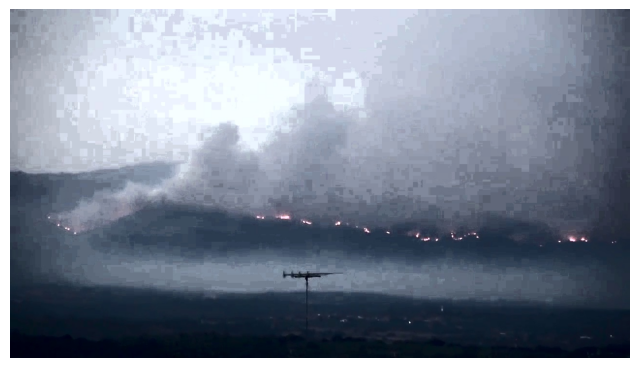

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Path gambar
img_path = "/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_HE/72:8:20/testNEW/images/WEB07008.jpg"
#img_path = "/content/drive/MyDrive/RBDM_Vita/NewD-Fire/72:8:20/test/images/WEB07008.jpg"

# Baca gambar dengan OpenCV
img = cv2.imread(img_path)

# Konversi dari BGR (OpenCV) ke RGB (matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Tampilkan gambar
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [ ]:
!yolo detect predict \
  model=/content/drive/MyDrive/RBDM_Vita/YoloResult/72:8:20/runs_YOLOv12_CLAHE_640/train/weights/best.pt \
  source='/content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images' \
  imgsz=640 \
  save=True \
  save_conf=True \
  line_thickness=2 \
  exist_ok=True


WARNING ⚠️ 'line_thickness' is deprecated and will be removed in in the future. Use 'line_width' instead.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs

image 1/4306 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images/AoF00011.jpg: 384x640 (no detections), 83.8ms
image 2/4306 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images/AoF00012.jpg: 384x640 (no detections), 13.8ms
image 3/4306 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images/AoF00020.jpg: 352x640 (no detections), 81.3ms
image 4/4306 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images/AoF00021.jpg: 384x640 (no detections), 13.9ms
image 5/4306 /content/drive/MyDrive/RBDM_Vita/YOLO12NewDFire_CLAHE/72:8:20/testNEW/images/AoF00041.jpg: 384x640 (no detections), 13.0ms
image 6/4306 /content/drive/MyDri

In [ ]:
import shutil
import os

# Correct path for training results
source_path = '/content/runs/detect/predict'  # ← change this!
destination_path = '/content/drive/MyDrive/RBDM_Vita/YoloResult/72:8:20/runs_YOLOv12_CLAHE_640/predict2'  # ← adjust this as needed

# Check if source exists
if not os.path.exists(source_path):
    print(f"❌ Error: Source directory '{source_path}' not found.")
else:
    # Count files before copying
    source_files = sum([len(files) for _, _, files in os.walk(source_path)])
    os.makedirs(destination_path, exist_ok=True)

    # Copy with overwrite
    shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

    # Count copied files
    destination_files = sum([len(files) for _, _, files in os.walk(destination_path)])

    if destination_files >= source_files:
        print(f"✅ Training results successfully saved to:\n{destination_path}")
        print(f"📁 Files copied: {destination_files}/{source_files}")
    else:
        print(f"⚠️ Warning: Incomplete copy. Only {destination_files}/{source_files} files copied.")


✅ Training results successfully saved to:
/content/drive/MyDrive/RBDM_Vita/YoloResult/72:8:20/runs_YOLOv12_CLAHE_640/predict2
📁 Files copied: 7766/7766


In [ ]:
import shutil
from google.colab import files

# Path of your training results in Colab
source_path = '/content/runs/detect/predict'

# Create a zip file of the results
zip_path = '/content/NEW_predictresults_CLAHE'
shutil.make_archive(zip_path, 'zip', source_path)

# Download the zip to local computer
files.download(zip_path + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>